In [1]:
import neat
import os
import evogym.envs
from evogym import is_connected, has_actuator, get_full_connectivity, hashable
import numpy as np
from pathos.multiprocessing import ProcessPool
import errno
import dill
import sys
sys.path.append('../')

import neat
from hyperneat.new_hyperNEAT import create_phenotype_network
from hyperneat.substrate import Substrate
from hyperneat.visualize import draw_net

import itertools as it
import time
import imageio

import sgr_main as sgr
from matplotlib import pyplot as plt


from substrates import morph_substrate, control_substrate
from generate_robot import generate_robot
from evogym_sim import simulate_env
from body_speciation import new_distance


In [2]:
def get_robot(genome, params, neat_config):
    cppn = neat.nn.FeedForwardNetwork.create(genome, neat_config)

    design_substrate = morph_substrate(params)
    design_net = create_phenotype_network(cppn, design_substrate)

    robot = generate_robot(design_net, params)
    if not sgr.eval_genome_constraint(robot):
        return robot, None
    connections = get_full_connectivity(robot)
    env = evogym.envs.gym.make(params["env"], body=robot, connections=connections)
    img = env.render(mode='img')
    env.close()
    return robot, img

In [6]:
ENV = "ObstacleTraverser-v1" # env_names = ["CaveCrawler-v0", "UpStepper-v0", "ObstacleTraverser-v1"]
STEPS = 600
ROBOT_SIZE = 5
POP = 128

# directory = "results/" + ENV
directory = "results/dynamic"

file = "run_1_pop_gen_10.pkl"
defaultGen = neat.DefaultGenome
f = lambda self, other, config: new_distance(params, morph_substrate(params), generate_robot, self, other, config)
# defaultGen.distance = f
params = {"robot_size": ROBOT_SIZE, "env": ENV, "steps": STEPS, "pop_size": POP, "robot_substrate": "AA"}
neat_config = neat.config.Config(
    defaultGen,
    neat.reproduction.DefaultReproduction, 
    neat.species.DefaultSpeciesSet, 
    neat.stagnation.DefaultStagnation, 
    "../configs/hyperNEAT_3D_out_robot.cfg"
)

with open(f"../{directory}/{file}", "rb") as file:
    pop = dill.load(file)
champion = pop.best_genome
print(champion.fitness)

-0.29398159127583684


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! Specie  19 !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
461 -0.9199400265236553


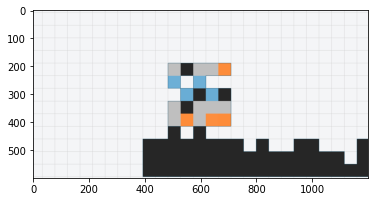

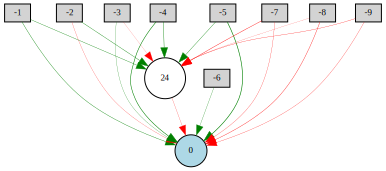

464 -0.5912607512876652


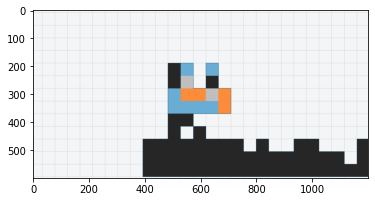

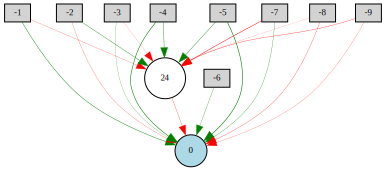

465 -0.6157500620050826


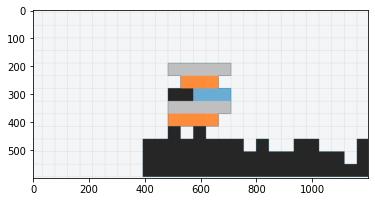

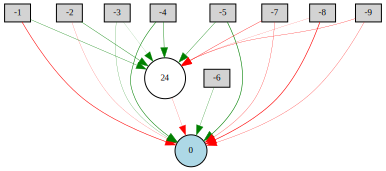

466 -0.6934526376002039


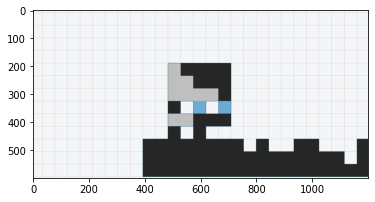

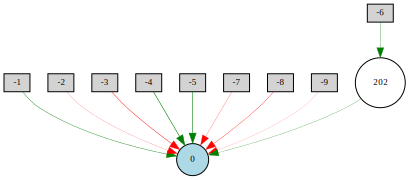

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! Specie  15 !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
188 -0.6977321970442256


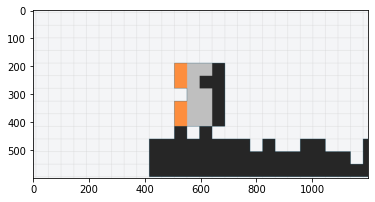

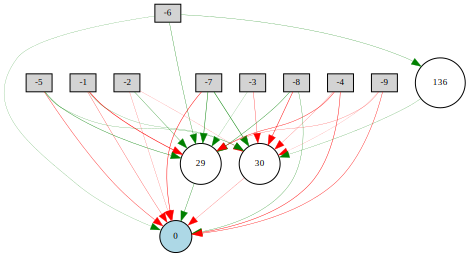

467 -0.7684074753638911


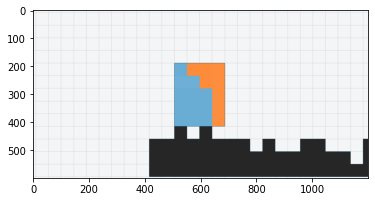

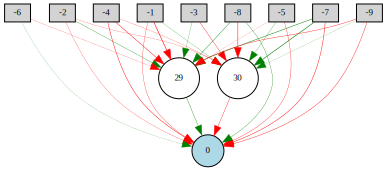

469 -0.4889494145058626


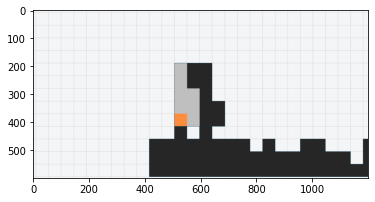

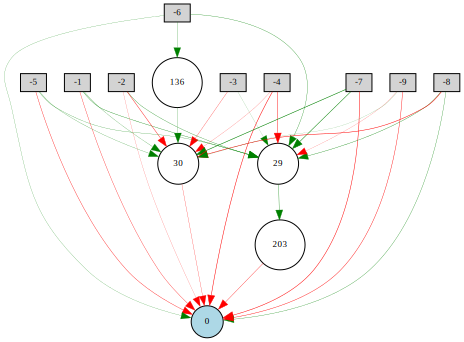

498 -1.4893575845509375


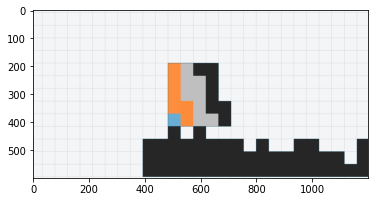

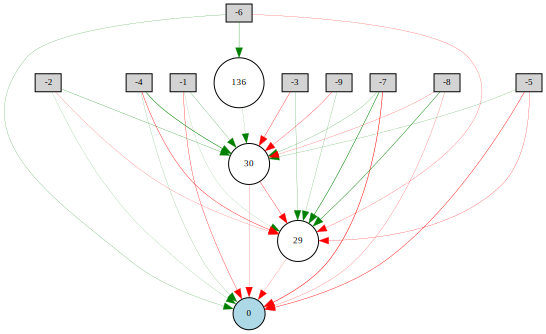

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! Specie  7 !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
28 -2.12030061994714


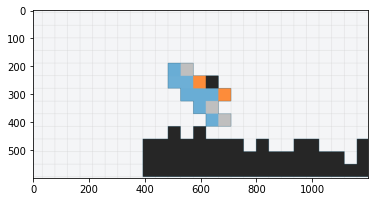

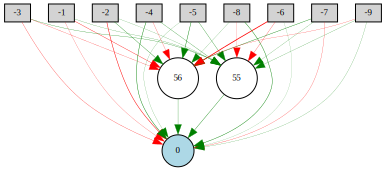

472 0.004272817813066154


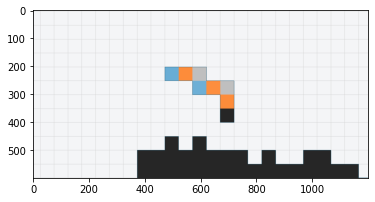

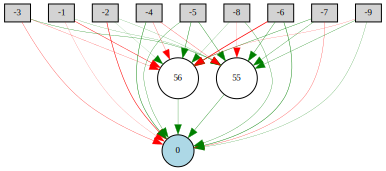

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! Specie  17 !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
425 -0.5650343608889583


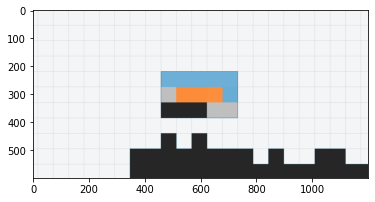

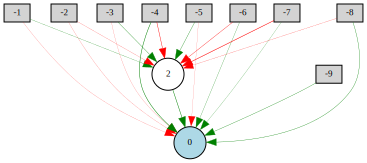

290 -0.10058415230991247


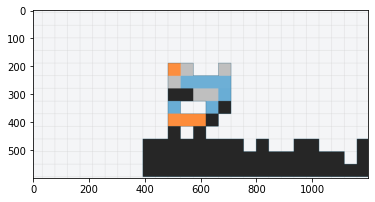

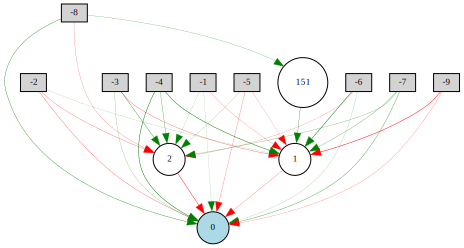

361 -0.46479932381936795


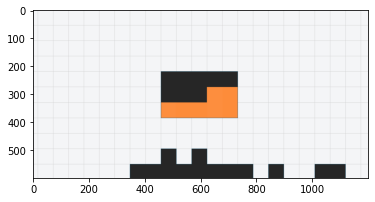

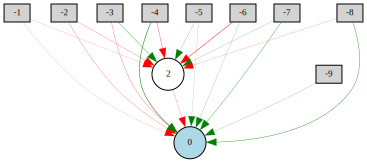

474 -1.5827701489292845


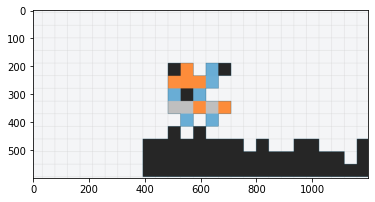

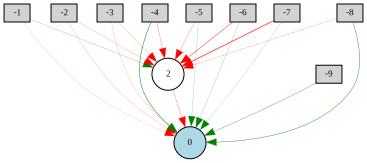

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! Specie  1 !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
202 -0.9981121418359825


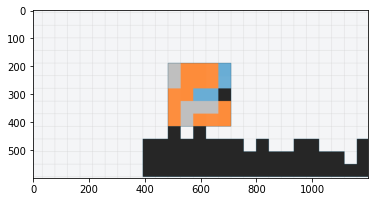

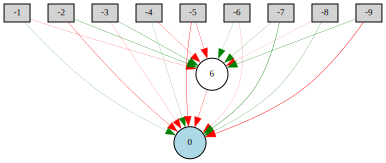

512 -0.9143402475733758


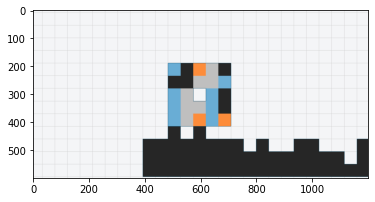

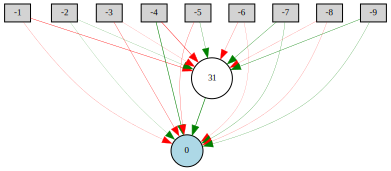

427 -0.6686806074618612


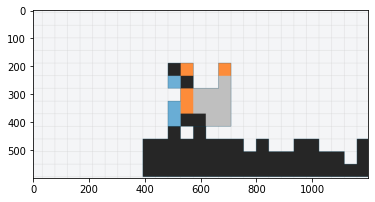

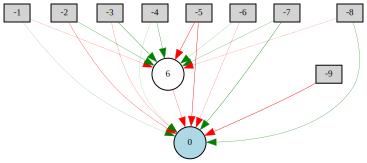

475 -0.436383608453449


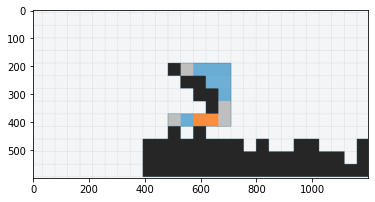

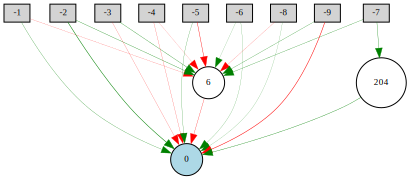

476 -0.9362813772970562


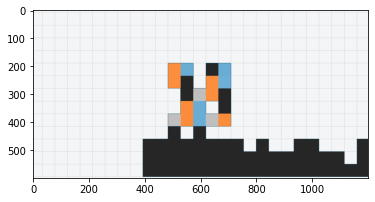

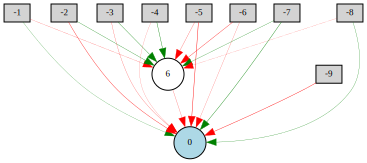

479 -0.6906048674897567


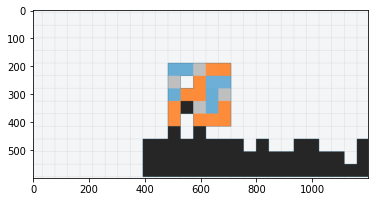

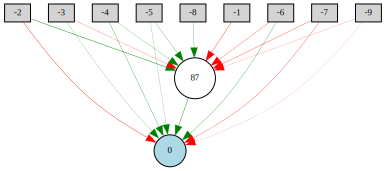

483 -1.1789703675140133


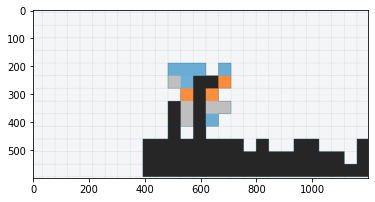

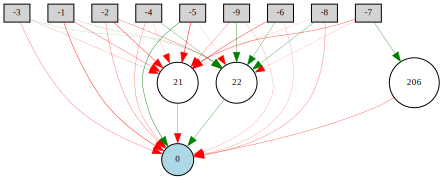

485 -1.0099311482893933


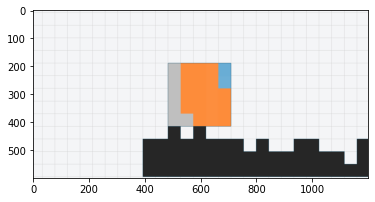

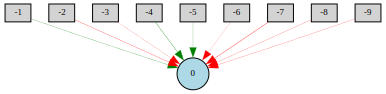

496 -1.0724880353659834


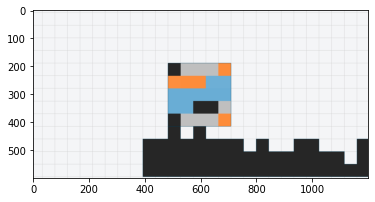

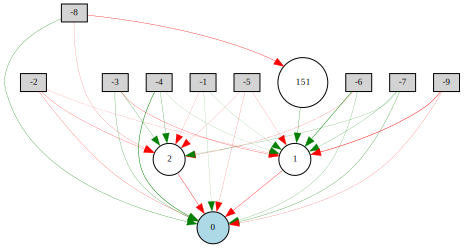

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! Specie  12 !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
376 -0.5950600984264856


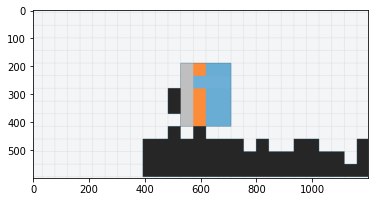

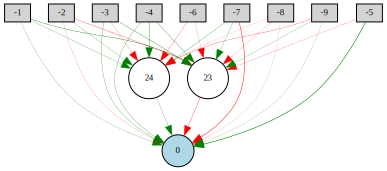

377 -0.8998131045236832


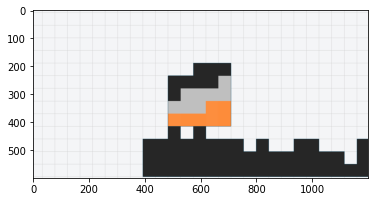

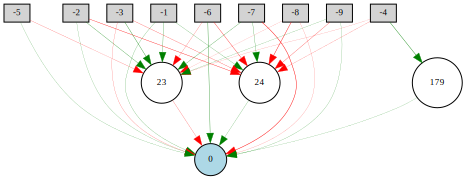

477 -0.7609113453921186


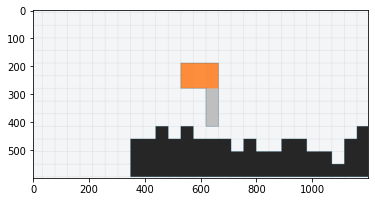

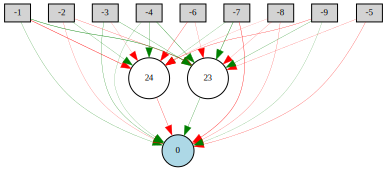

478 -0.6811919266298083


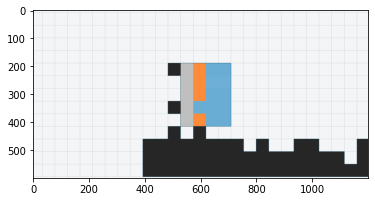

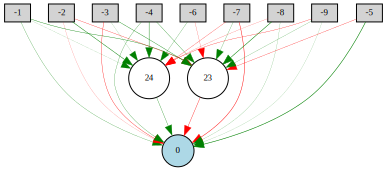

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! Specie  18 !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
281 -0.9189647913285626


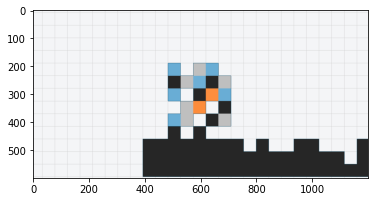

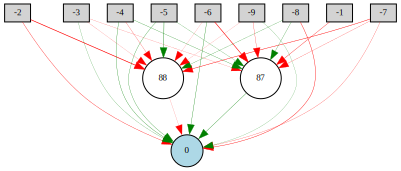

386 -1.2076035333788493


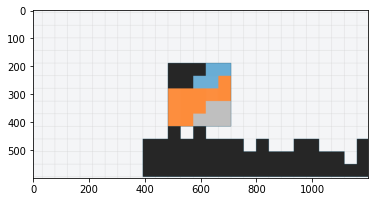

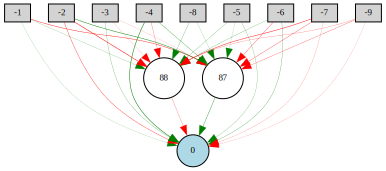

480 -1.3827720854560686


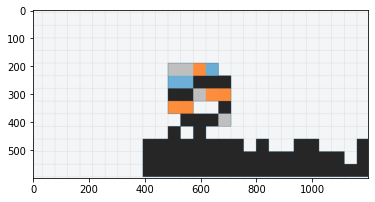

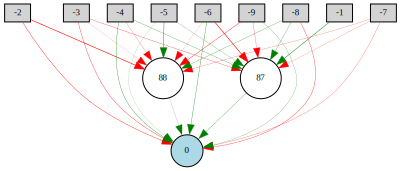

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! Specie  4 !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
215 -0.41360912223802704


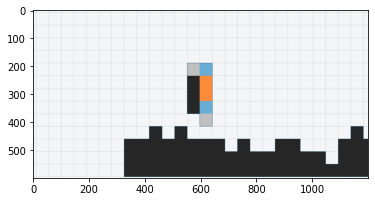

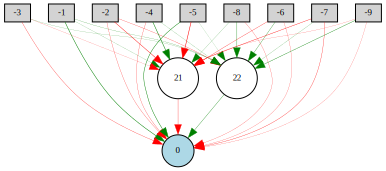

341 -0.34722608955490286


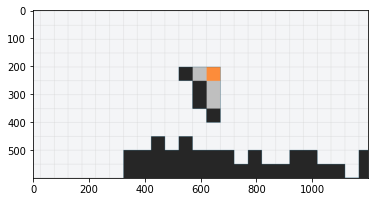

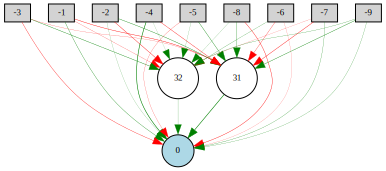

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! Specie  6 !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
442 -0.5525153725169326


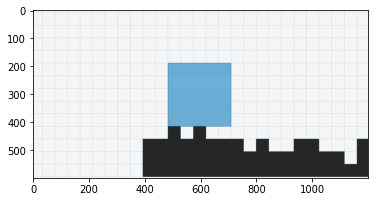

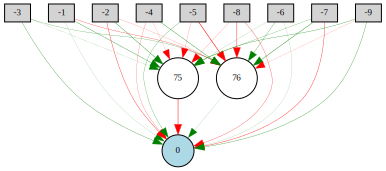

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! Specie  16 !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
486 -1.0270377841577933


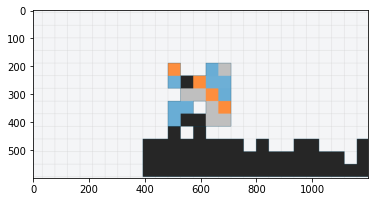

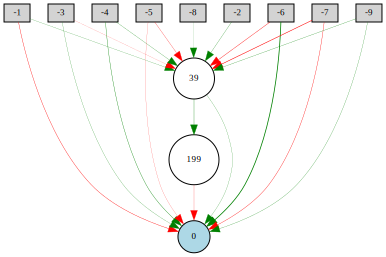

420 -0.5399708345716259


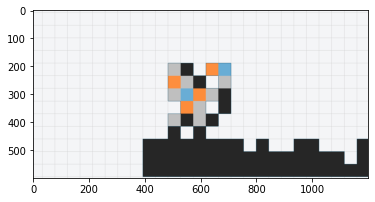

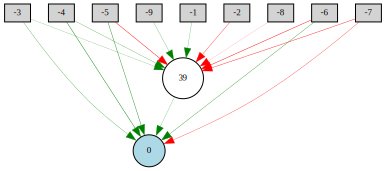

449 -0.6424087472112379


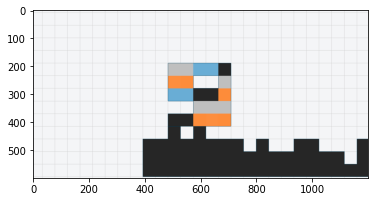

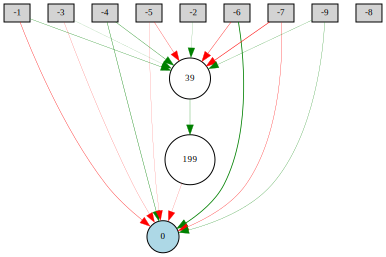

505 -0.762466337310669


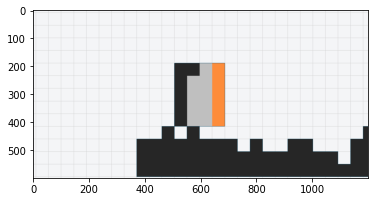

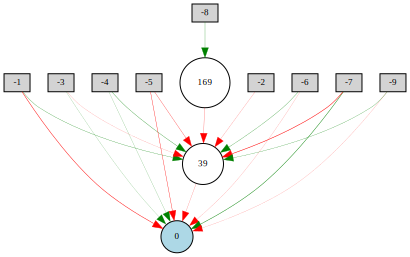

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! Specie  9 !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
166 -0.6636947044064755


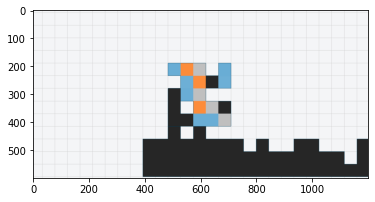

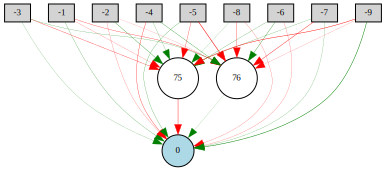

441 -0.4893773035998127


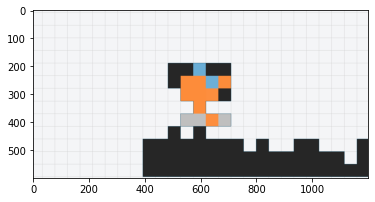

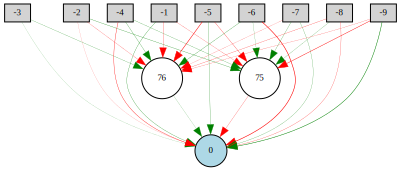

488 -0.6349096604957392


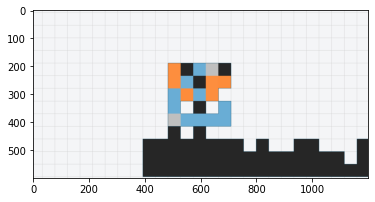

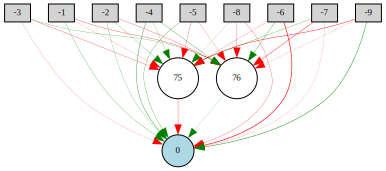

500 0.006580883704650542


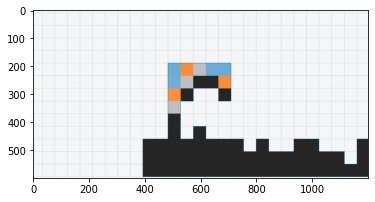

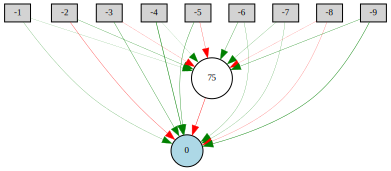

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! Specie  13 !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
138 -1.2137354318859161


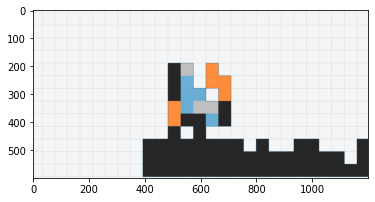

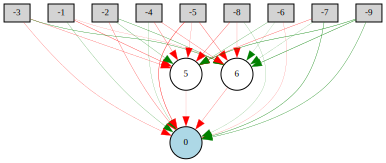

432 -0.7210308640723857


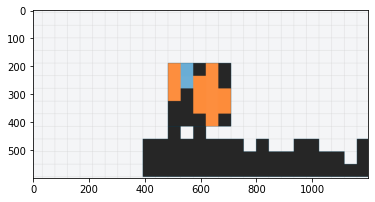

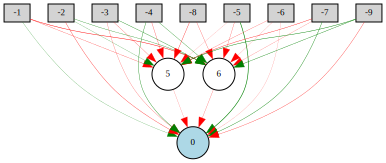

490 -1.1282723705596664


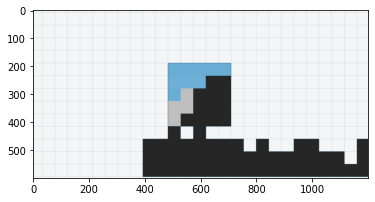

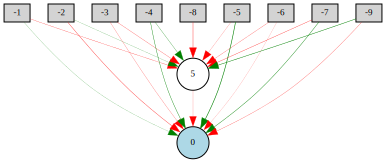

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! Specie  8 !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
92 -0.13678882384103563


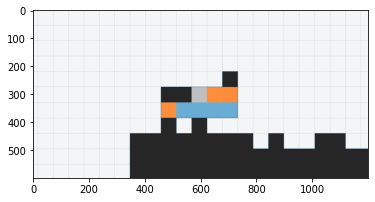

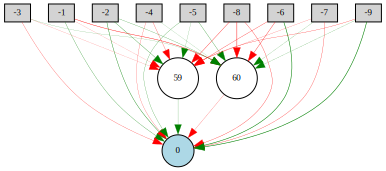

353 -0.5799588085766818


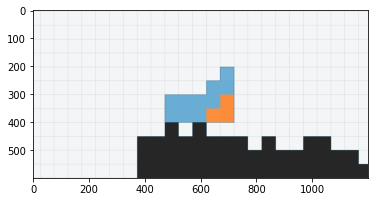

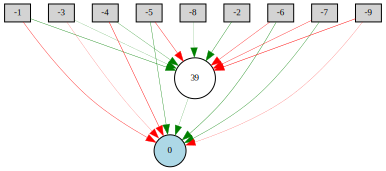

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! Specie  14 !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
117 -0.07191995004256846


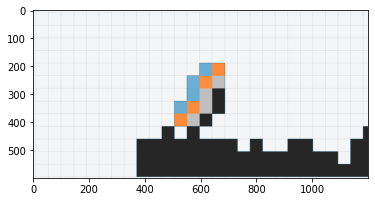

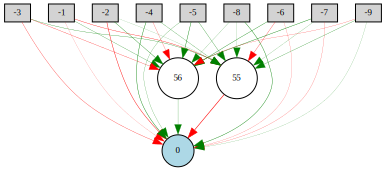

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! Specie  2 !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
443 -0.36568329120629967


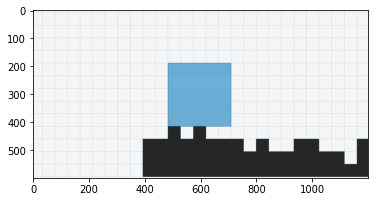

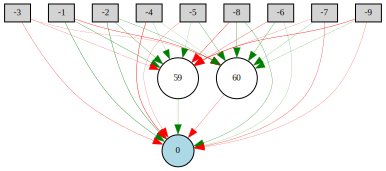

452 -0.699571565083606


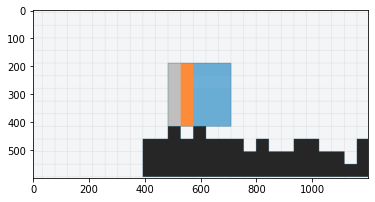

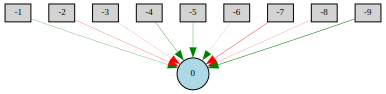

492 -1.1092345087799922


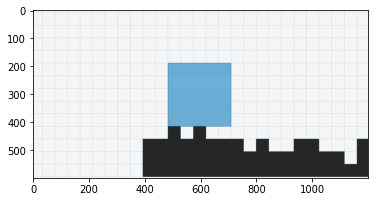

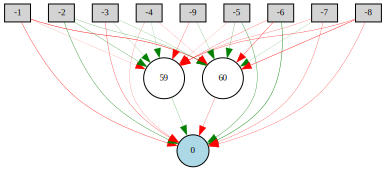

493 -0.30740490053924185


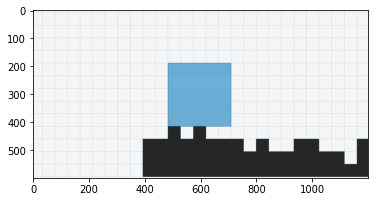

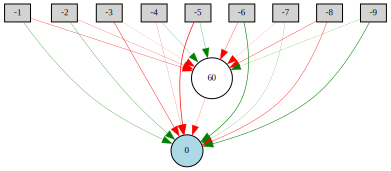

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! Specie  3 !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
305 -0.57859949978521


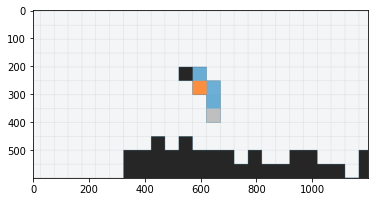

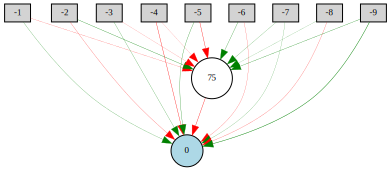

499 -0.8247447165865999


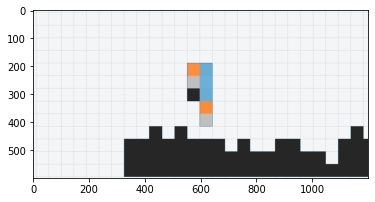

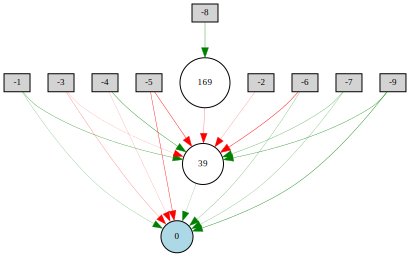

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! Specie  11 !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
119 -1.09474559618865


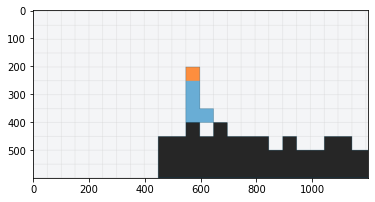

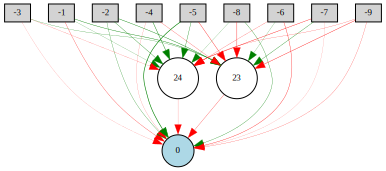

460 0.007276297588408198


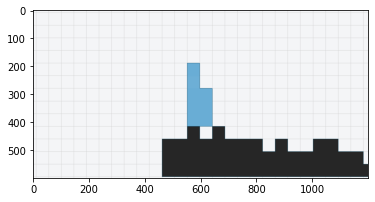

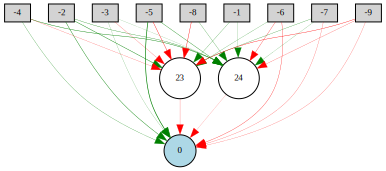

507 -0.004262710666147307


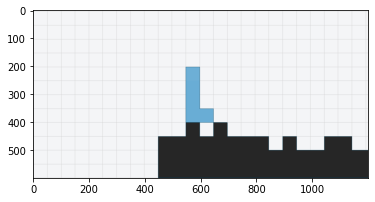

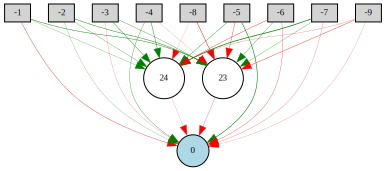

508 -0.6739739899183593


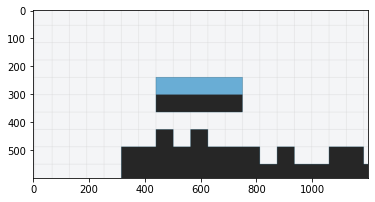

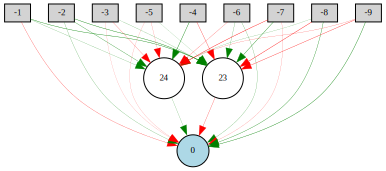

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! Specie  10 !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
364 -0.014027315751302005


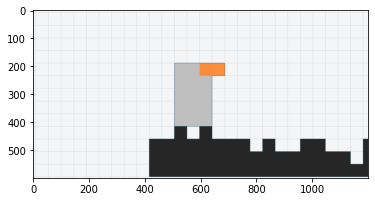

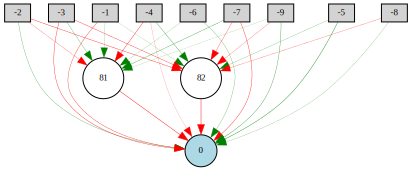

302 0.07858475904975692


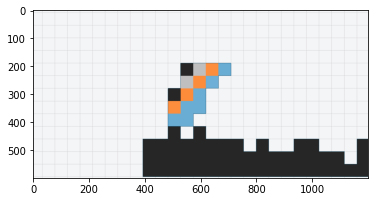

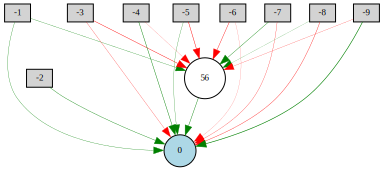

503 -0.6213560773984861


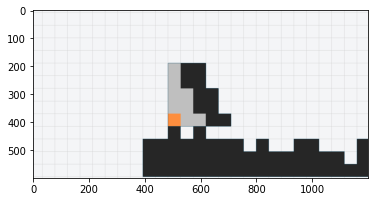

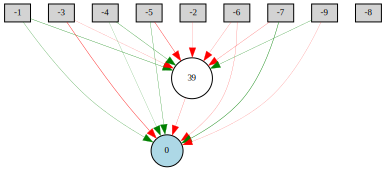

509 -1.6229442724396754


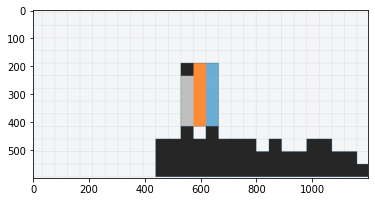

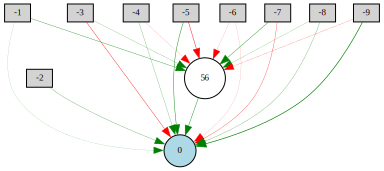

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! Specie  5 !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
261 -0.29398159127583684


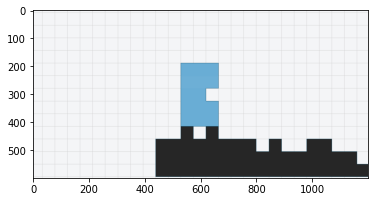

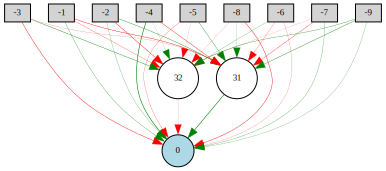

276 -0.2229928940917622


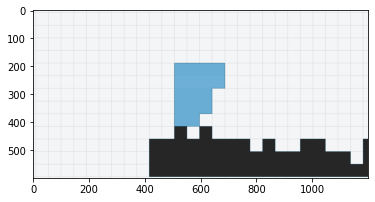

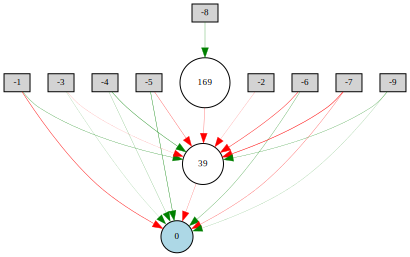

470 -0.0692527597799778


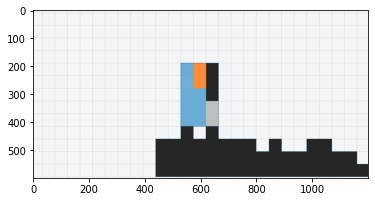

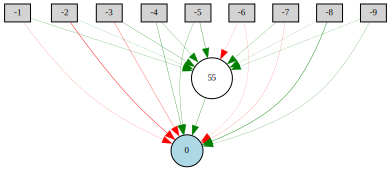

491 -0.3657089809159622


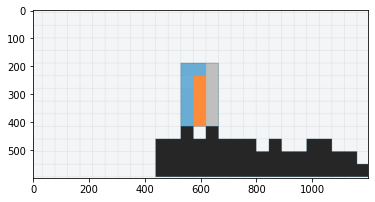

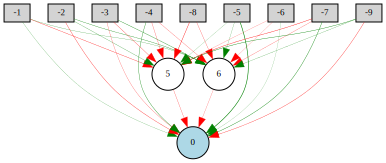

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! Specie  20 !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
435 -0.9702245917613808


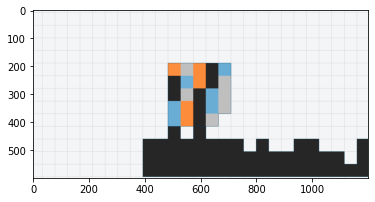

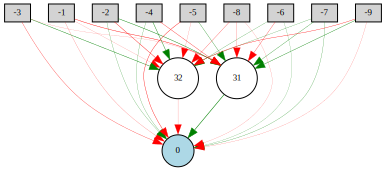

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! Specie  21 !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
497 -0.9897884431576308


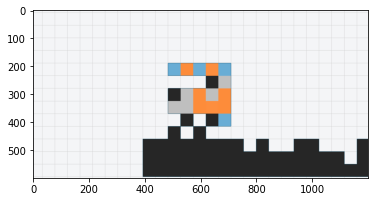

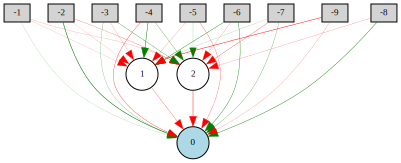

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! Specie  22 !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
502 -5.132727721500919


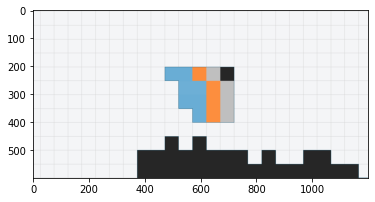

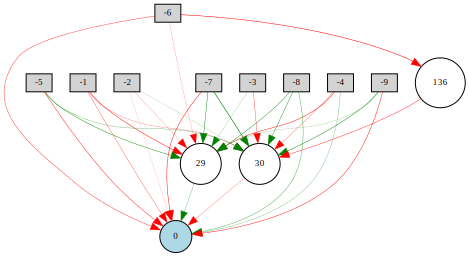

In [7]:
for k, v in pop.species.species.items():
    print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! Specie ", k, "!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
    for g in v.members.values():
        # if g.fitness != None and g.fitness > .2:
        r, img = get_robot(g, params, neat_config)
        if img is not None:
            print(g.key, g.fitness)
            plt.imshow(img)
            plt.show()
            net = neat.nn.FeedForwardNetwork.create(g, neat_config)
            display(draw_net(net))

In [8]:
# g = champion
g = pop.population[500]
params["save_to"] = "flipper_bipedal"
sgr.single_genome_fit(g, params, neat_config, True, False)
# sgr.single_genome_fit(g, params, neat_config, False, True)

(-0.011164207181897368, False)

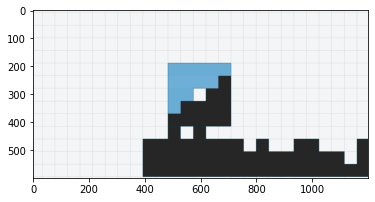

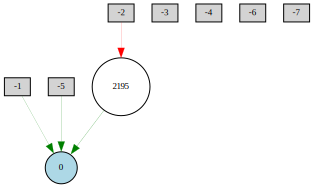

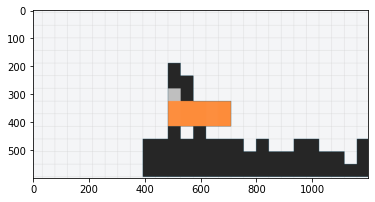

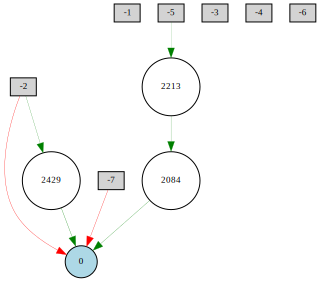

4.716327532073551

2.7363275320735507


In [8]:
base = pop.population[12892]
r2 = pop.population[14520]

_, img = get_robot(base, params, neat_config)
plt.imshow(img)
plt.show()
net = neat.nn.FeedForwardNetwork.create(base, neat_config)
display(draw_net(net))

_, img = get_robot(r2, params, neat_config)
plt.imshow(img)
plt.show()
net = neat.nn.FeedForwardNetwork.create(r2, neat_config)
display(draw_net(net))


neat_config.compatibility_disjoint_coefficient = 1
neat_config.compatibility_weight_coefficient = .6

base.distance = f
print(base.distance(base, r2, neat_config))


print()

base.distance =  neat.DefaultGenome.distance
print(base.distance(base, r2, neat_config))
